Steps
-----

1. Analyze the percentage of missing values stratified by clinical diagnosis and for the whole sample.
2. Estimate imputation errors through a missing value introduction experiment.
3. Perform a statistical comparison of the data distributions before and after the imputation.

In [1]:
import os 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind, ttest_rel
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge

sns.set()

In [ ]:
# configuration parameters
DATA_PATH = os.path.join('..', 'Data')
DATA_FILE = 'MainDataset.csv'

# Dictionary with the cognitive variables used and nomenclature in English
COGNITIVE_TEST = {
    # digit span forward and backward
    "Spandirecto": "Digit span forward",
    "Spanindirecto": "Digit span backward",
    
    # Corsi’s test forward and backward,
    "Corsidirecto": "Corsi’s test forward",                 
    "Corsiinverso": "Corsi’s test backward",    
    
    # Trail Making Test part A and B
    "TMTa": "TMT A",
    "TMTb": "TMT B",
    
    # Symbol Digit Modalities Test
    "SDMT": "SDMT",
    
    # Stroop Color-Word Interference test
    "Stroop1": "SCWIT word reading",
    "Stroop2": "SCWIT color naming",
    "Stroop3": "SCWIT interference",
    
    # Tower of London-Drexel version
    "ToLtotalcorrectos": "ToL correct",
    "ToLmovtotales"    : "ToL movements",
    "ToLinicio"        : "ToL start",
    "ToLejecucion"     : "ToL execution",
    "ToLresolucion"    : "ToL resolution",
    
    # Boston Naming Test
    "BostonNT": "BNT",
    
    # Semantic fluency (animals)
    "Fluenciaanimalesescalar": "Semantic fluency", 
    
    # Letter fluency (words beginning with “p”),
    "FluenciaPescalar": "Letter fluency",
    
    # Free and Cued Selective Reminding Test
    "FCSRTL1"      : "FCSRT free recall 1",                           
    "FCSRTLT"      : "FCSRT total free recall",                           
    "FCSRTtotal"   : "FCSRT total recall",                     
    "FCSRTdifLibre": "FCSRT delayed free recall",               
    "FCSRTdifTOTAL": "FCSRT delayed total recall",       
    
    # Rey-Osterrieth Complex Figure (copy accuracy, copy time, memory at 3 and 30 minutes, and recognition memory)
    "ReyCopia"         : "ROCF copy accuracy",
    "Rey3min"          : "ROCF memory 3 min",
    "Rey30min"         : "ROCF memory 30 min" ,
    "ReyTiempo"        : "ROCF time",
    "ReyReconocimiento": "ROCF recognition",
    
    # Benton’s Judgment Line Orientation,
    "JLOescalar": "JLO",
    
    # Visual Object and Space Perception Battery (object decision, progressive silhouettes, 
    # discrimination of position, and number location
    "VOSPdecision"     : "VOSP object decision",
    "VOSPsiluetas"     : "VOSP progressive silhouettes",
    "VOSPdiscriposi"   : "VOSP discrimination of position",
    "VOSPlocaliznumero": "VOSP number location"

}
    
# Dictionary with the brain regions of the AAL atlas corrected
BRAIN_DATA_AAL = {
    'precentral_i': 'precentral_l',
    'precentral_d': 'precentral_r',
    'postcentral_i': 'postcentral_l',
    'postcentral_d': 'postcentral_r',
    'opercroland_i': 'rolandic_oper_l',
    'opercroland_d': 'rolandic_oper_r',
    'frontalsup_i': 'frontal_sup_l',
    'frontalsup_d': 'frontal_sup_r',
    'frontalmedio_i': 'frontal_mid_l',
    'frontalmedio_d': 'frontal_mid_r',
    'frontalinferoper_i': 'frontal_inf_oper_l',
    'frontalinferoper_d': 'frontal_inf_oper_r',
    'frontalinftri_i': 'frontal_inf_tri_l',
    'frontalinftri_d': 'frontal_inf_tri_r',
    'frontalsupmed_i': 'frontal_sup_medial_l',
    'frontalsupmed_d': 'frontal_sup_medial_r',
    'motorsuple_i': 'supp_motor_area_l',
    'motorsuple_d': 'supp_motor_area_r',
    'paracentral_i': 'paracentral_lobule_l',
    'paracentral_d': 'paracentral_lobule_r',
    'frontalsuporb_i': 'frontal_sup_orb_l',
    'frontalsuporb_d': 'frontal_sup_orb_r',
    'frontalmedorb_ii': 'frontal_med_orb_l',
    'frontalmedorb_dd': 'frontal_med_orb_r',
    'frontalmedioorb_i': 'frontal_mid_orb_l',
    'frontalmedioorb_d': 'frontal_mid_orb_r',
    'frontalinforb_i': 'frontal_inf_orb_l',
    'frontalinforb_d': 'frontal_inf_orb_r',
    'recto_i': 'rectus_l',
    'recto_d': 'rectus_r',
    'olf_i': 'olfactory_l',
    'olf_d': 'olfactory_r',
    'tempsuper_i': 'temporal_sup_l',
    'tempsuper_d': 'temporal_sup_r',
    'heschl_i': 'heschl_l',
    'heschl_d': 'heschl_r',
    'temporalmed_i': 'temporal_mid_l',
    'temporalmed_d': 'temporal_mid_r',
    'tempinf_i': 'temporal_inf_l',
    'tempinf_d': 'temporal_inf_r',
    'parietalsup_i': 'parietal_sup_l',
    'parietalsup_d': 'parietal_sup_r',
    'parietalinf_i': 'parietal_inf_l',
    'parietalinf_d': 'parietal_inf_r',
    'angular_i': 'angular_l',
    'angular_d': 'angular_r',
    'supramarginal_i': 'supramarginal_l',
    'supramarginal_d': 'supramarginal_r',
    'precuneus_i': 'precuneus_l',
    'precuneus_d': 'precuneus_r',
    'occipsup_i': 'occipital_sup_l',
    'occipsup_d': 'occipital_sup_r',
    'occipmed_i': 'occipital_mid_l',
    'occipmed_d': 'occipital_mid_r',
    'occipinf_i': 'occipital_inf_l',
    'occipinf_d': 'occipital_inf_r',
    'cuneus_i': 'cuneus_l',
    'cuneus_d': 'cuneus_r',
    'calcarino_i': 'calcarine_l',
    'calcarino_d': 'calcarine_r',
    'lingual_i': 'lingual_l',
    'lingual_d': 'lingual_r',
    'fusiforme_i': 'fusiform_l',
    'fusiforme_d': 'fusiform_r',
    'polotempsup_i': 'temporal_pole_sup_l',
    'polotempsup_d': 'temporal_pole_sup_r',
    'polotempmed_i': 'temporal_pole_mid_l',
    'polotempmed_d': 'temporal_pole_mid_r',
    'cinguant_i': 'cingulum_ant_l',
    'cinguant_d': 'cingulum_ant_r',
    'cingumed_i': 'cingulum_mid_l',
    'cingumed_d': 'cingulum_mid_r',
    'cingupost_i': 'cingulum_post_l',
    'cingupost_d': 'cingulum_post_r',
    'hipocampo_i': 'hippocampus_l',
    'hipocampo_d': 'hippocampus_r',
    'parahipocampo_i': 'parahippocampal_l',
    'parahipocampo_d': 'parahippocampal_r',
    'insula_i': 'insula_l',
    'insula_d': 'insula_r',
    'amigdala_i': 'amygdala_l',
    'amigdala_d': 'amygdala_r',
    'caudado_i': 'caudate_l',
    'caudado_d': 'caudate_r',
    'putamen_i': 'putamen_l',
    'putamen_d': 'putamen_r',
    'palido_i': 'pallidum_l',
    'palido_d': 'pallidum_r',
    'talamo_i': 'thalamus_l',
    'talamo_d': 'thalamus_r'
}

# Dictionary with the demographic variables
DEMO_DATA = {
    'Sexo': 'sex',
    'Edadactual': 'age',
    'AñosEducacion': 'years_of_formal_education',
}

assert os.path.exists(DATA_PATH)
assert os.path.exists(os.path.join(DATA_PATH, DATA_FILE))

# Data preparation

In [3]:
# load the data
df = pd.read_csv(os.path.join(DATA_PATH, DATA_FILE))

# remove subjects without a diagnosis of HC/FTD/AD
df = df.loc[~(df['DiagnosticoClinico'] == 17)].copy()

# correct sex variable
df['Sexo'] = df['Sexo'] - 1

# code clinical diagnosis
df['diagnosis'] = np.nan

df.loc[
    df['DiagnosticoClinico'].isin([
        3
    ]), 'diagnosis'] = 'bvFTD'

df.loc[
    df['DiagnosticoClinico'].isin([
        13, 16
    ]), 'diagnosis'] = 'HC'

df.loc[
    df['DiagnosticoClinico'].isin([
        7, 5
    ]), 'diagnosis'] = 'AD'

df['diagnosis'].value_counts()

# format the final data
df = df[
    list(DEMO_DATA.keys()) +
    list(COGNITIVE_TEST.keys()) +
    list(BRAIN_DATA_AAL.keys()) +
    ['diagnosis']
].rename(columns={
    **DEMO_DATA,
    **COGNITIVE_TEST,
    **BRAIN_DATA_AAL
}).copy()

# correct values
df.loc[df["SCWIT color naming"] > 20, 'SCWIT color naming'] = np.nan
df.loc[df["SCWIT interference"] < 2.0, "SCWIT interference"] = 2.0
df.loc[df["BNT"] > 20, 'BNT'] = np.nan

# for patients with dementia imputate the missing values in ToL and Rey
# using the lower values as these patients didn't complete the test because
# they cognitive impairment
variables_floor_imputation = [
    "ToL correct",
    "ToL movements",
    "ToL start",
    "ToL execution",
    "ToL resolution",
    "ROCF copy accuracy",
    "ROCF memory 3 min",
    "ROCF memory 30 min" ,
    "ROCF time",
    "ROCF recognition",
]

for var in variables_floor_imputation:
    df.loc[
        df.diagnosis.isin(['AD', 'bvFTD']) &
        df[var].isna(), var] = 2.0

# Analyze cognitive variables distribution

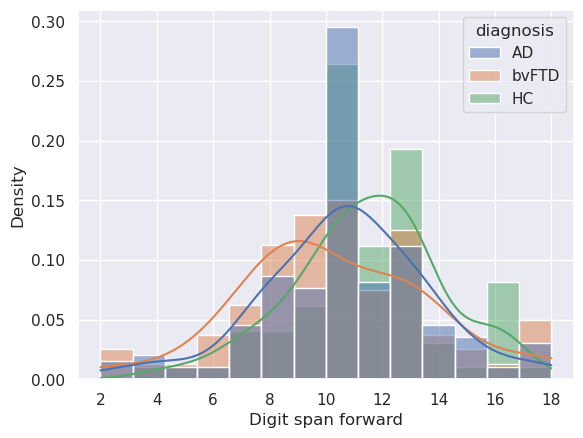

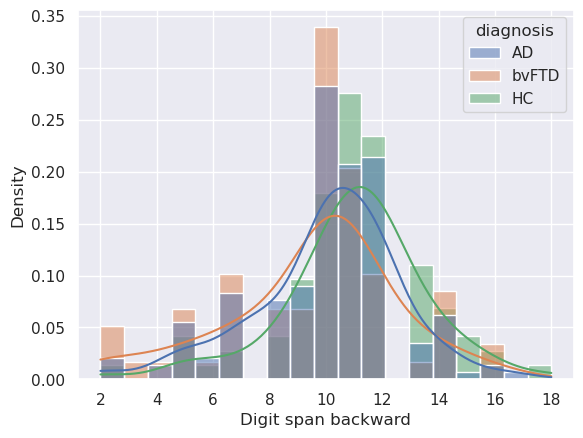

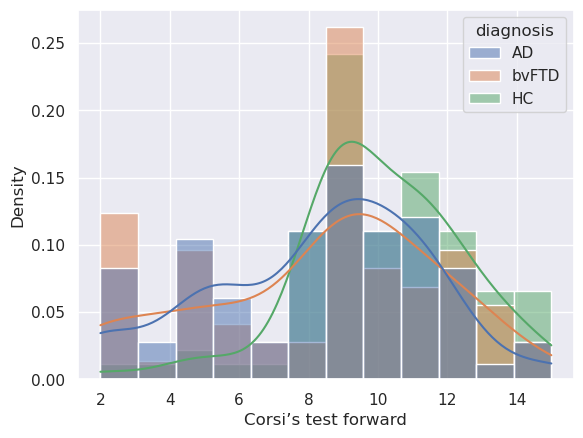

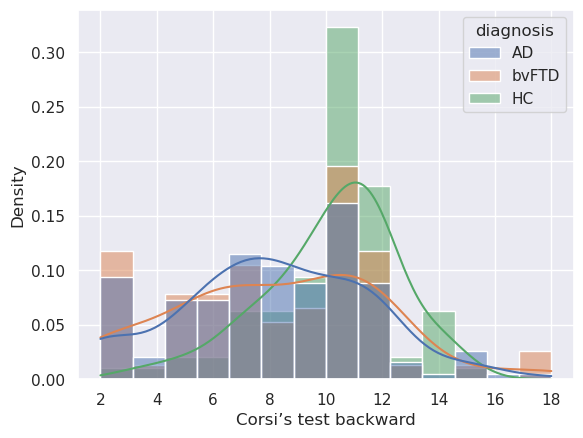

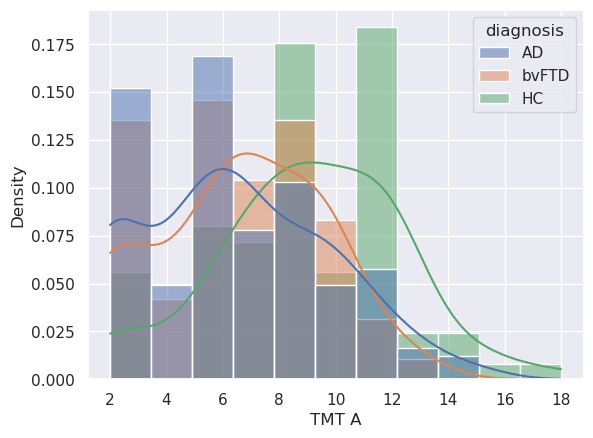

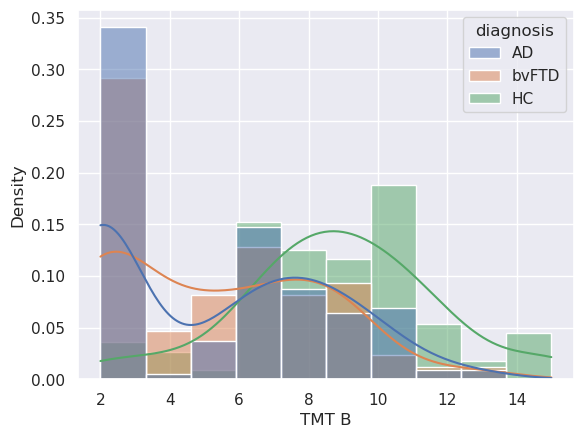

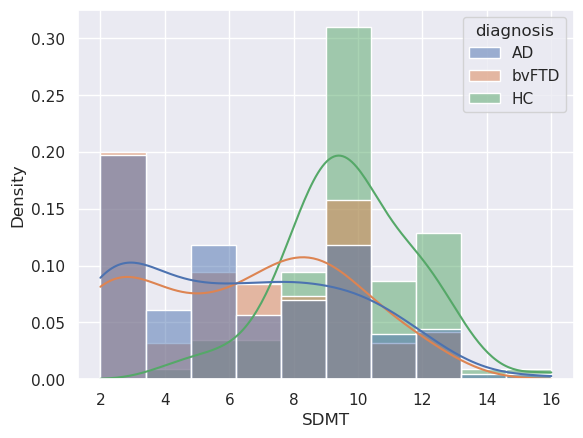

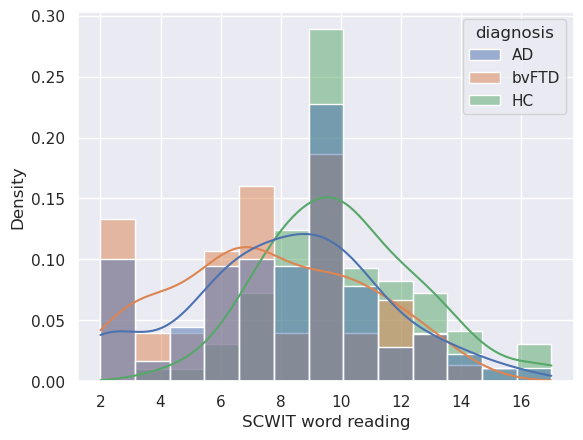

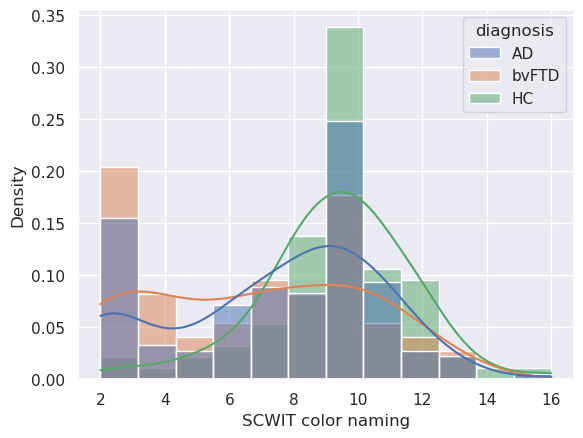

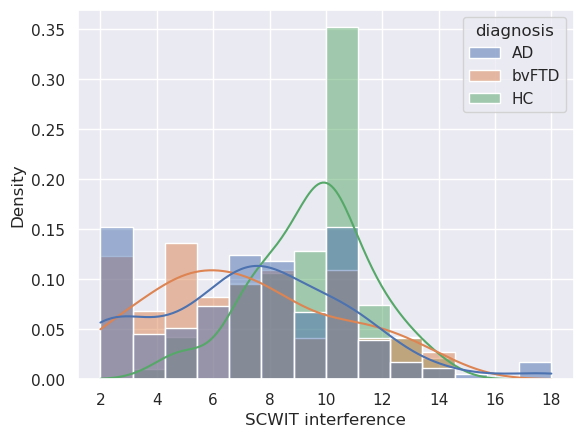

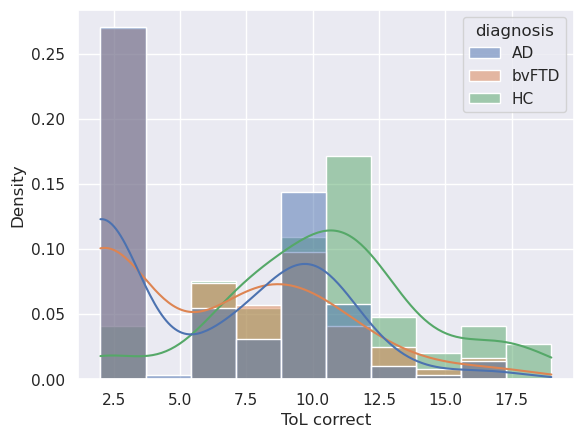

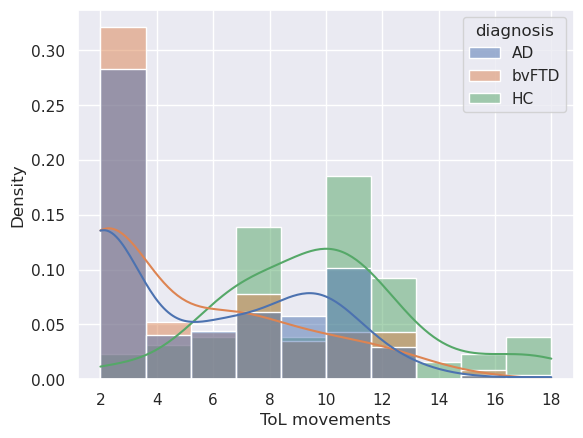

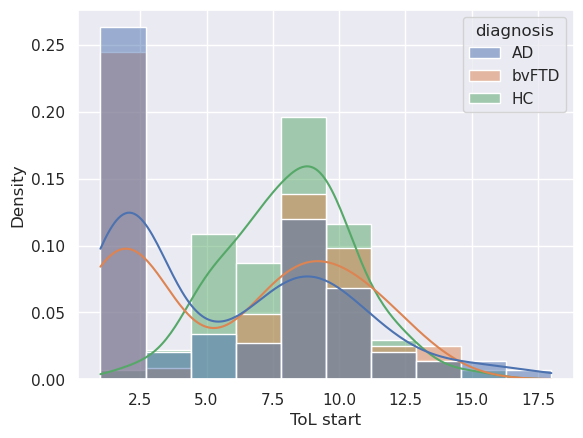

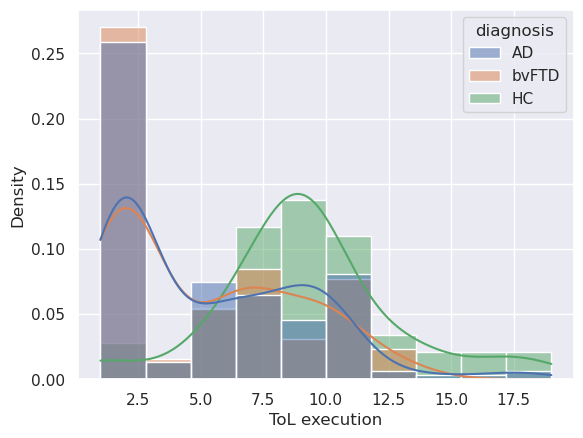

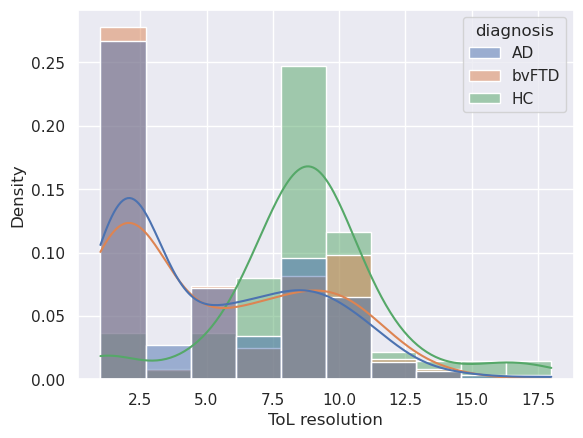

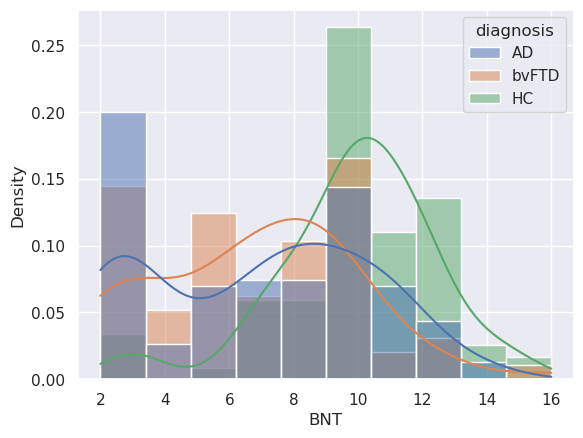

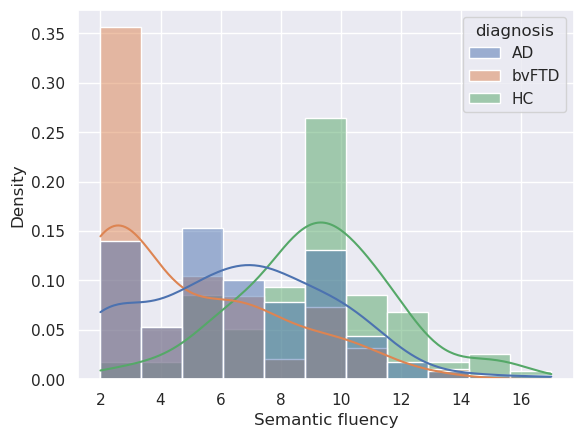

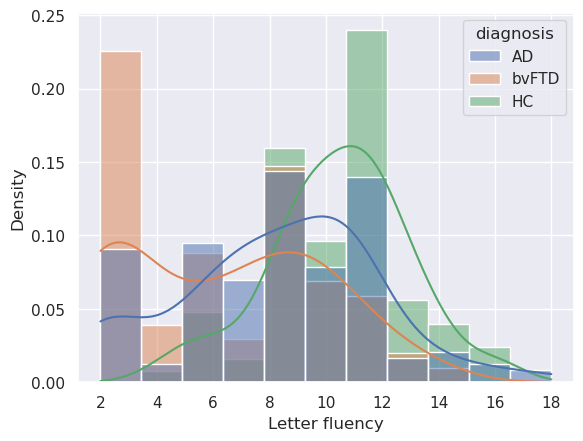

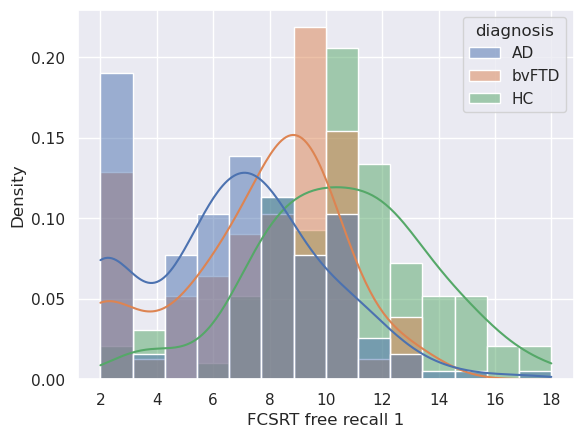

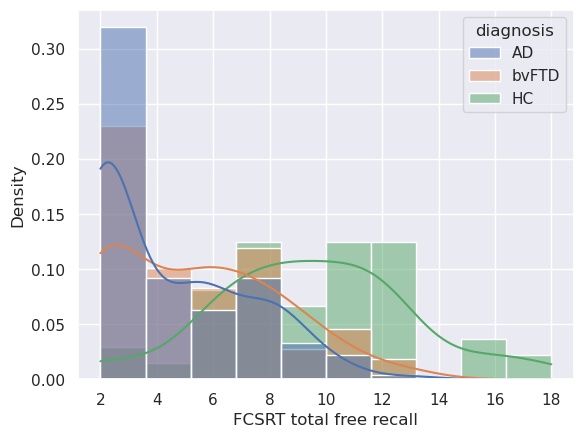

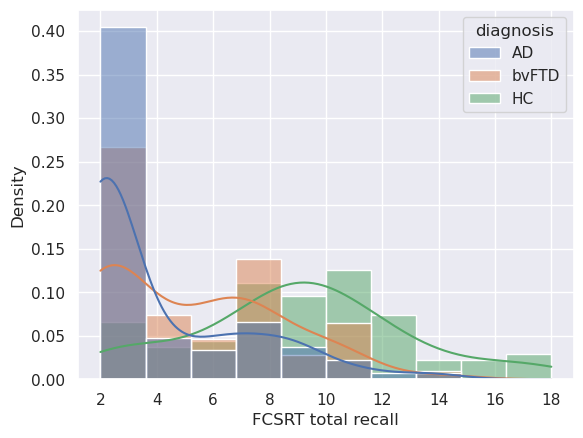

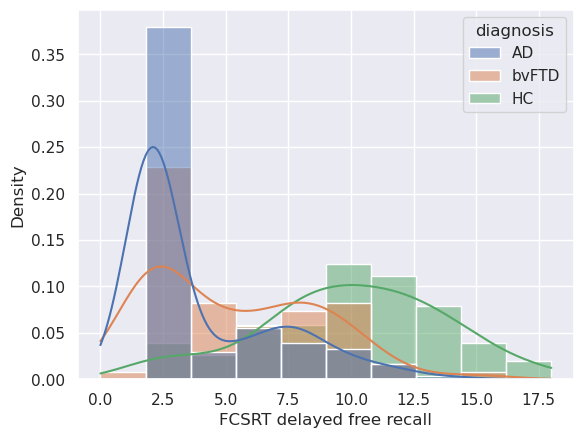

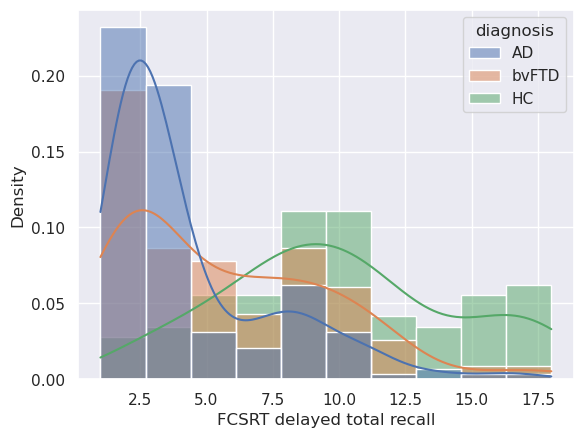

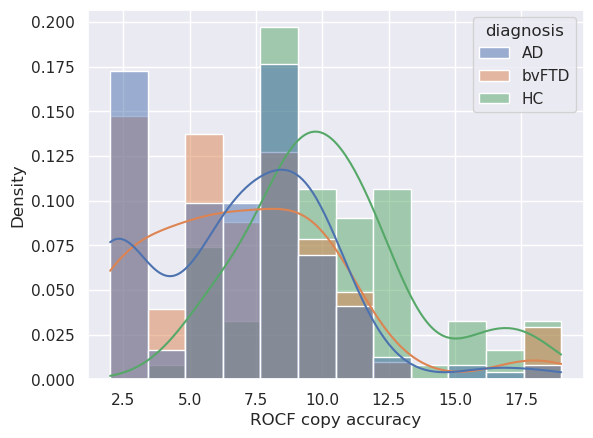

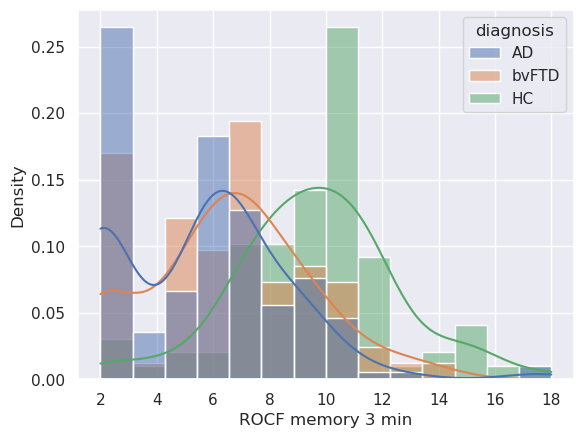

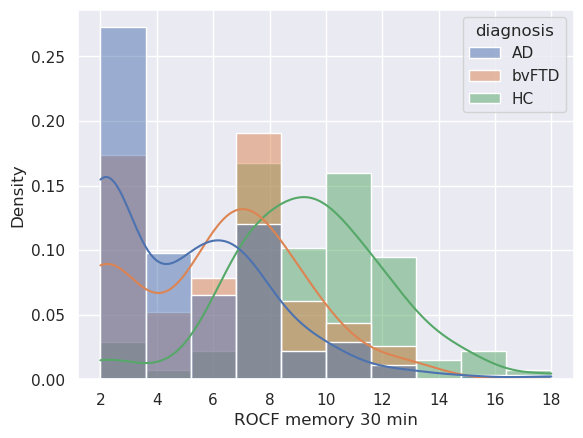

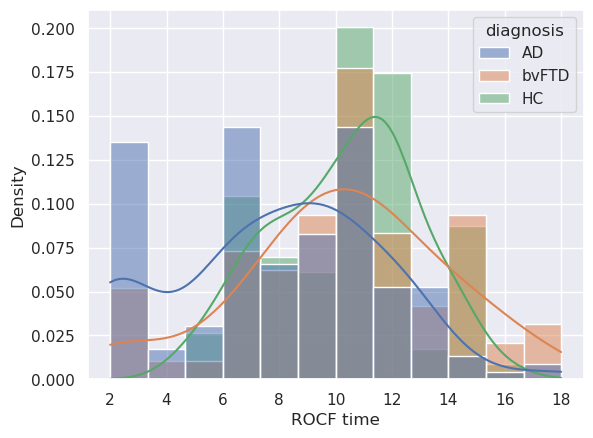

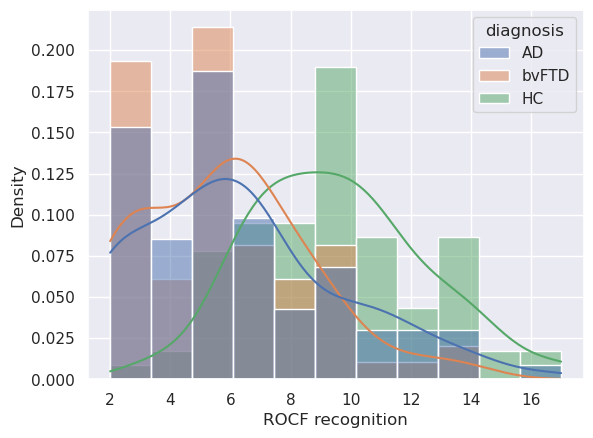

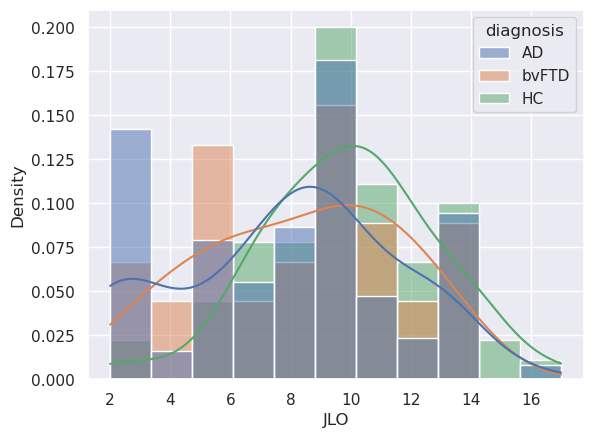

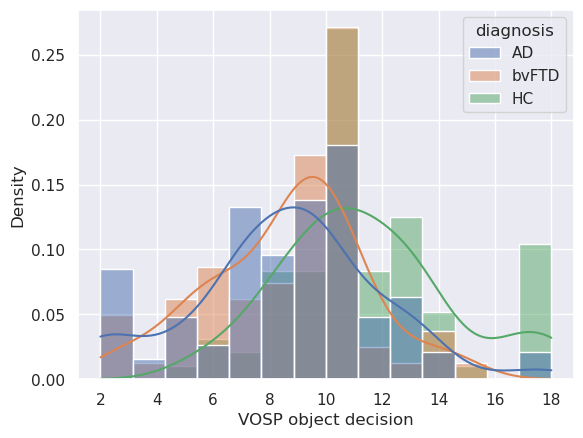

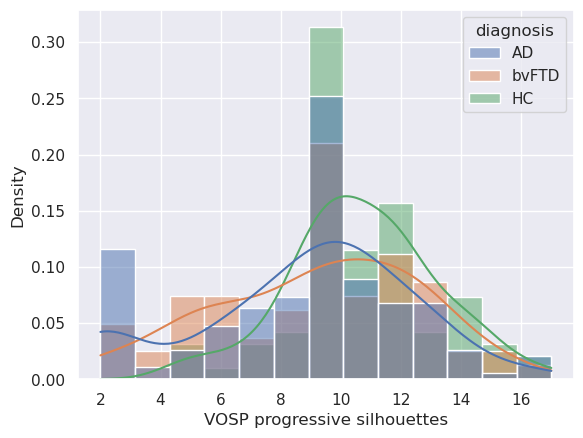

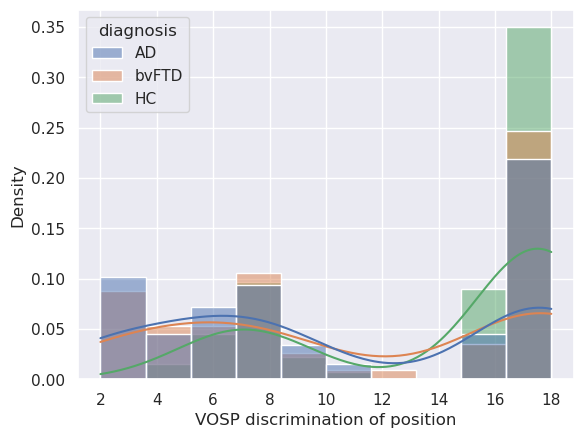

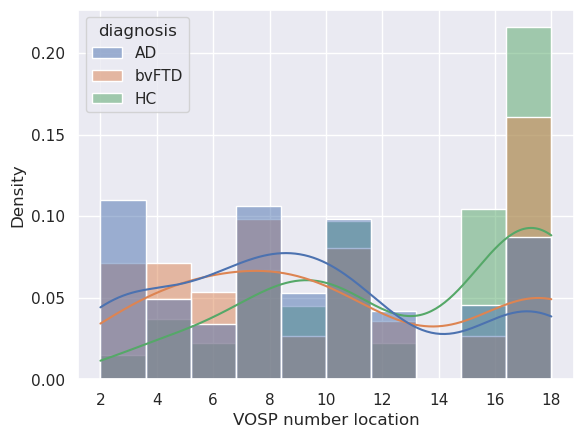

In [4]:
for var in COGNITIVE_TEST.values():
    sns.histplot(
        data=df, 
        x=var,
        hue='diagnosis',
        stat='density',
        common_norm=False,
        kde=True,
        hue_order=['AD', 'bvFTD', 'HC']
    )

    plt.show()

# Analyze missing values profile

In [5]:
missing_profile = pd.concat([
    df.isna().sum(),
    (df.isna().sum() / df.shape[0]) * 100
], axis=1)
missing_profile.columns = ['n_missing', 'perc_missing']
missing_profile = missing_profile.loc[missing_profile['n_missing'] > 0].copy().sort_values(by='n_missing', ascending=False)
missing_profile

,n_missing,perc_missing
JLO,138,41.818182
SCWIT color naming,31,9.393939
SCWIT interference,29,8.787879
SCWIT word reading,25,7.575758
SDMT,16,4.848485
BNT,13,3.939394
VOSP progressive silhouettes,12,3.636364
VOSP number location,11,3.333333
TMT B,11,3.333333
TMT A,11,3.333333


In [6]:
# select variables with missing variables
variables_with_missings = list(df.isna().sum().loc[df.isna().sum() > 0].index)   # select those with more than un 5% of missing values

In [7]:
# perform a chi2 test to compare the profile of missing values across conditions
chi2_results = []
for var in variables_with_missings:
    contingency_table = pd.crosstab(
        df[var].isna().astype(int),
        df['diagnosis'])
    chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)
    
    # calculate percentages of missing values
    perc_missing = ((1 - (df.groupby('diagnosis')[var].count() / df.groupby('diagnosis')['sex'].count())) * 100).to_dict()
    n_missing = (df.groupby('diagnosis')['sex'].count()  - df.groupby('diagnosis')[var].count()).to_dict()

    chi2_results.append({
        'Variable': var,
        'HC': '{:.0f} ({:.1f}%)'.format(n_missing['HC'], perc_missing['HC']),
        'AD': '{:.0f} ({:.1f}%)'.format(n_missing['AD'], perc_missing['AD']),
        'bvFTD': '{:.0f} ({:.1f}%)'.format(n_missing['bvFTD'], perc_missing['bvFTD']),
        
        'Statistic': '{:.2f}{}'.format(chi2_stat, '' if p_val > 0.05 else '*'),
    })
chi2_results_df = pd.DataFrame(chi2_results)
chi2_results_df

,Variable,HC,AD,bvFTD,Statistic
0,Digit span forward,0 (0.0%),0 (0.0%),2 (2.8%),7.21*
1,Digit span backward,0 (0.0%),0 (0.0%),2 (2.8%),7.21*
2,Corsi’s test forward,2 (2.3%),4 (2.3%),5 (6.9%),3.73
3,Corsi’s test backward,2 (2.3%),4 (2.3%),5 (6.9%),3.73
4,TMT A,0 (0.0%),5 (2.9%),6 (8.3%),8.65*
5,TMT B,0 (0.0%),5 (2.9%),6 (8.3%),8.65*
6,SDMT,3 (3.5%),9 (5.2%),4 (5.6%),0.48
7,SCWIT word reading,2 (2.3%),16 (9.3%),7 (9.7%),4.59
8,SCWIT color naming,5 (5.8%),17 (9.9%),9 (12.5%),2.16
9,SCWIT interference,4 (4.7%),17 (9.9%),8 (11.1%),2.58


# Perform imputation 

## KNN imputation

In [8]:
# create a copy of the data to be imputed
df_knn = df[
    list(COGNITIVE_TEST.values()) + 
    list(DEMO_DATA.values())].copy()

# create imputer (same configuration than the one used by Pedro)
knn_imputer = KNNImputer(
    n_neighbors=5,
    weights='uniform',
)

# standarize the data
scaler = StandardScaler()
scaler = scaler.fit(df_knn)
df_knn_std = scaler.transform(df_knn)

# imputate the data
df_knn_imp = knn_imputer.fit_transform(df_knn_std)

# de-standarize the variables
df_knn_imp = scaler.inverse_transform(df_knn_imp)
df_knn_imp = pd.DataFrame(
    df_knn_imp, 
    columns=df_knn.columns,
    index=df_knn.index)

In [9]:
diags = df['diagnosis'].unique()
ttest_results_knn = []
for var in variables_with_missings:
    for diag in diags:
        var_na_mask = df[var].isna()
        diag_mask = df['diagnosis'] == diag
        
        # compute statistics only if there is more than 10 cases
        if (var_na_mask & diag_mask).sum() > 5:
            
            # select imputed and non-imputed values
            var_ori_vals = df.loc[(~var_na_mask) & diag_mask, var].values
            var_imp_vals = df_knn_imp.loc[var_na_mask & diag_mask, var].values
            
            # perform t-test
            ttest_result = ttest_ind(var_ori_vals, var_imp_vals)

            ttest_results_knn.append(
                {
                    'Variable': var,
                    'Diagnosis': diag,
                    'N (imputed)': len(var_imp_vals),
                    'Mean (non-imputed)': np.mean(var_ori_vals),
                    'Mean (imputed)': np.mean(var_imp_vals),
                    #'Mean (HC)': df.loc[df['diagnosis'] == 'HC', var].mean(),
                    #'Std (non-imputed)': np.std(var_ori_vals),
                    #'Std (imputed)': np.std(var_imp_vals),
                    'T-test (statistic)': ttest_result.statistic,
                    'T-test (p-value)': ttest_result.pvalue
                }
            )
            
ttest_results_knn_df = pd.DataFrame(ttest_results_knn).round(decimals=3)
ttest_results_knn_df

,Variable,Diagnosis,N (imputed),Mean (non-imputed),Mean (imputed),T-test (statistic),T-test (p-value)
0,TMT A,bvFTD,6,6.591,5.433,0.893,0.375
1,TMT B,bvFTD,6,5.333,4.633,0.543,0.589
2,SDMT,AD,9,6.380,3.822,2.254,0.025
3,SCWIT word reading,AD,16,8.128,6.025,2.477,0.014
4,SCWIT word reading,bvFTD,7,7.585,7.029,0.456,0.650
5,SCWIT color naming,AD,17,7.477,5.706,2.161,0.032
6,SCWIT color naming,bvFTD,9,6.794,6.844,-0.043,0.966
7,SCWIT interference,AD,17,7.406,5.718,1.907,0.058
8,SCWIT interference,bvFTD,8,7.109,6.900,0.173,0.863
9,BNT,AD,8,6.915,4.650,1.838,0.068


In [15]:
ttest_results_knn_df.to_clipboard()

## MICE - Bayesian ridge imputation

In [10]:
# create a copy of the data to be imputed
df_mice = df[
    list(COGNITIVE_TEST.values()) + 
    list(DEMO_DATA.values())].copy()

# create imputer (same configuration than the one used by Pedro)
mice_imputer = IterativeImputer(
    estimator=BayesianRidge(), 
    max_iter=100,
    random_state=1997

)

# standarize the data
scaler = StandardScaler()
scaler = scaler.fit(df_mice)
df_mice_std = scaler.transform(df_mice)

# imputate the data
df_mice_imp = mice_imputer.fit_transform(df_mice_std)

# de-standarize the variables
df_mice_imp = scaler.inverse_transform(df_mice_imp)
df_mice_imp = pd.DataFrame(
    df_mice_imp, 
    columns=df_mice.columns,
    index=df_mice.index)

In [11]:
diags = df['diagnosis'].unique()
ttest_results_mice = []
for var in variables_with_missings:
    for diag in diags:
        var_na_mask = df[var].isna()
        diag_mask = df['diagnosis'] == diag
        
        # compute statistics only if there is more than 10 cases
        if (var_na_mask & diag_mask).sum() > 5:
            
            # select imputed and non-imputed values
            var_ori_vals = df.loc[(~var_na_mask) & diag_mask, var].values
            var_imp_vals = df_mice_imp.loc[var_na_mask & diag_mask, var].values
            
            # perform t-test
            ttest_result = ttest_ind(var_ori_vals, var_imp_vals)

            ttest_results_mice.append(
                {
                    'Variable': var,
                    'Diagnosis': diag,
                    'N (imputed)': len(var_imp_vals),
                    'Mean (non-imputed)': np.mean(var_ori_vals),
                    'Mean (imputed)': np.mean(var_imp_vals),
                    #'Mean (HC)': df.loc[df['diagnosis'] == 'HC', var].mean(),
                    #'Std (non-imputed)': np.std(var_ori_vals),
                    #'Std (imputed)': np.std(var_imp_vals),
                    'T-test (statistic)': ttest_result.statistic,
                    'T-test (p-value)': ttest_result.pvalue
                }
            )
            
ttest_results_mice_df = pd.DataFrame(ttest_results_mice).round(decimals=3)
ttest_results_mice_df

,Variable,Diagnosis,N (imputed),Mean (non-imputed),Mean (imputed),T-test (statistic),T-test (p-value)
0,TMT A,bvFTD,6,6.591,5.290,1.007,0.317
1,TMT B,bvFTD,6,5.333,4.091,0.959,0.341
2,SDMT,AD,9,6.380,4.134,1.982,0.049
3,SCWIT word reading,AD,16,8.128,6.887,1.487,0.139
4,SCWIT word reading,bvFTD,7,7.585,7.214,0.304,0.762
5,SCWIT color naming,AD,17,7.477,6.245,1.526,0.129
6,SCWIT color naming,bvFTD,9,6.794,6.836,-0.036,0.971
7,SCWIT interference,AD,17,7.406,6.296,1.274,0.204
8,SCWIT interference,bvFTD,8,7.109,6.537,0.474,0.637
9,BNT,AD,8,6.915,5.234,1.370,0.173


## Imputation method comparison

In [12]:
ttest_method_comparison = []
for var in variables_with_missings:
    var_na_mask = df[var].isna()
    mice_vals = df_mice_imp.loc[var_na_mask, var].values
    knn_vals = df_knn_imp.loc[var_na_mask, var].values

    # perform t-test (paired)
    ttest_result = ttest_rel(mice_vals, knn_vals) 

    ttest_method_comparison.append({
        'Variable': var,
        'N (imputed)': var_na_mask.sum(),
        'Mean (KNN)': np.mean(knn_vals),
        'Mean (MICE)': np.mean(mice_vals),
        'Std (KNN)': np.std(knn_vals),
        'Std (MICE)': np.std(mice_vals),
        'T-test (statistic)': ttest_result.statistic,
        'T-test (p-value)': ttest_result.pvalue
    })
    
ttest_method_comparison_df = pd.DataFrame(ttest_method_comparison).round(decimals=3)
ttest_method_comparison_df

/home/fgarcia/anaconda3/envs/mlv0/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/fgarcia/anaconda3/envs/mlv0/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


,Variable,N (imputed),Mean (KNN),Mean (MICE),Std (KNN),Std (MICE),T-test (statistic),T-test (p-value)
0,Digit span forward,2,10.200,9.467,0.000,0.725,-1.011,0.496
1,Digit span backward,2,9.900,9.121,0.700,0.577,-0.610,0.651
2,Corsi’s test forward,11,8.273,7.728,1.443,1.212,-2.258,0.048
3,Corsi’s test backward,11,8.636,7.854,1.935,1.533,-2.192,0.053
4,TMT A,11,5.273,4.931,2.834,2.620,-1.158,0.274
5,TMT B,11,4.055,3.671,2.649,2.608,-1.172,0.268
6,SDMT,16,5.412,5.586,3.261,3.519,0.714,0.486
7,SCWIT word reading,25,6.488,7.169,2.683,2.209,2.889,0.008
8,SCWIT color naming,31,6.587,7.104,2.822,2.747,2.078,0.046
9,SCWIT interference,29,6.469,6.724,2.693,2.231,0.903,0.374


# Data exportation

In [13]:
# -- export data imputed using the MICE method

# add the imputed variables
df_final = df_mice_imp.join(
    df[[c for c in df.columns if c not in df_mice_imp.columns]],
    how='inner')

# code the diagnosis variable

df_final = df_final.join(
    pd.get_dummies(df_final[['diagnosis']]).astype(int),
    how='inner')

df_final.to_parquet(os.path.join('..', 'data', 'final_data_MICE.parquet'))